### Importing required Libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam



Using TensorFlow backend.


In [2]:
import os
#os.listdir('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')

## Loading the data and getting basic idea 

In [3]:
tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


## Class distribution

Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.

Text(0, 0.5, 'samples')

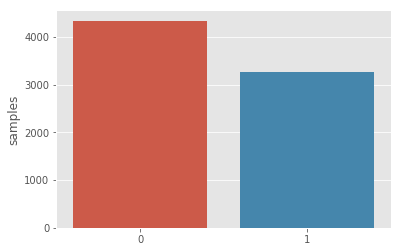

In [5]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

ohh,as expected ! There is a class distribution.There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

## Exploratory Data Analysis of tweets

First,we will do very basic analysis,that is character level,word level and sentence level analysis.

### Number of characters in tweets

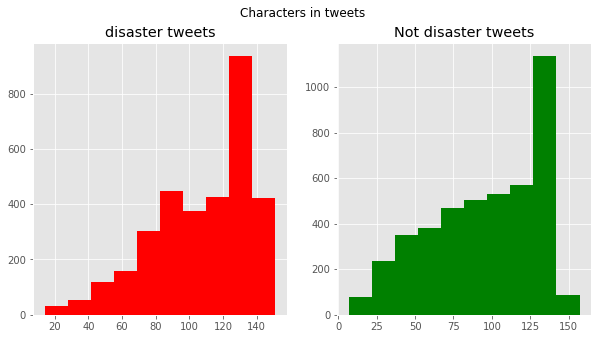

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()


The distribution of both seems to be almost same.120 t0 140 characters in a tweet are the most common among both.

### Number of words in a tweet

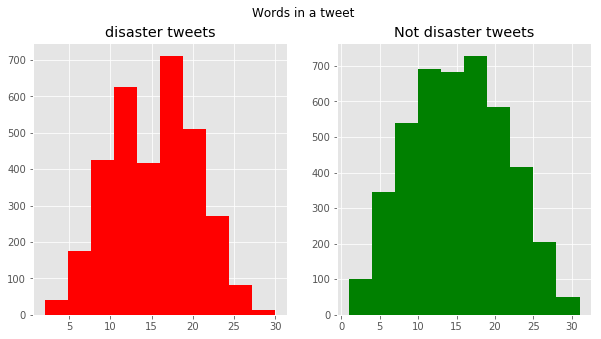

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


###  Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

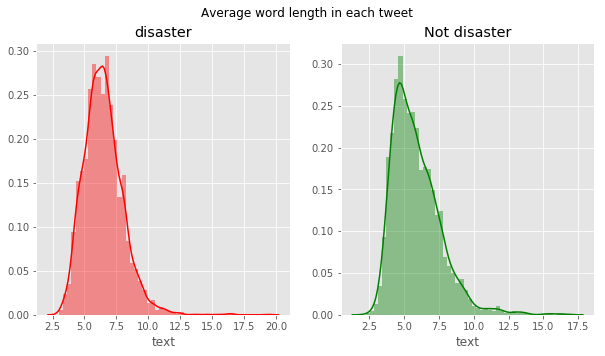

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [9]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Common stopwords in tweets

First we  will analyze tweets with class 0.

In [10]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 


<BarContainer object of 10 artists>

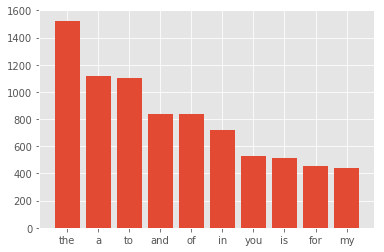

In [11]:
x,y=zip(*top)
plt.bar(x,y)

Now,we will analyze tweets with class 1.

<BarContainer object of 10 artists>

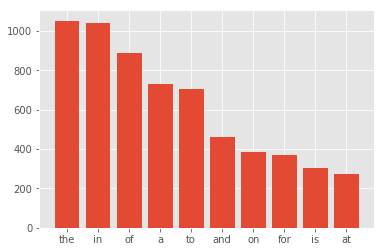

In [12]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

### Analyzing punctuations.

First let's check tweets indicating real disaster.

<BarContainer object of 18 artists>

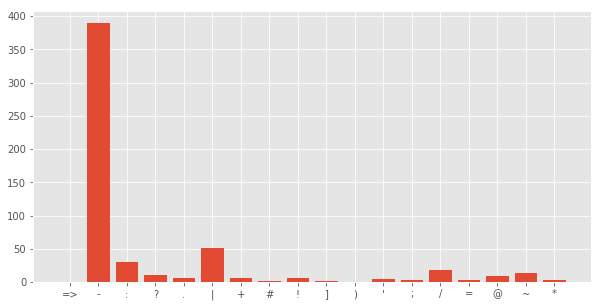

In [13]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Now,we will move on to class 0.

<BarContainer object of 20 artists>

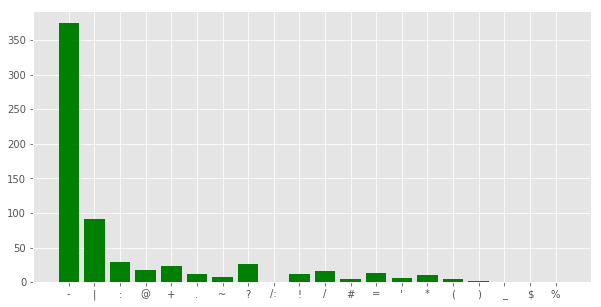

In [14]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

### Common words ?

In [15]:

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

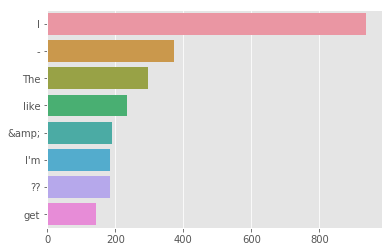

In [16]:
sns.barplot(x=y,y=x)

Lot of cleaning needed !

### Ngram analysis

we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [17]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

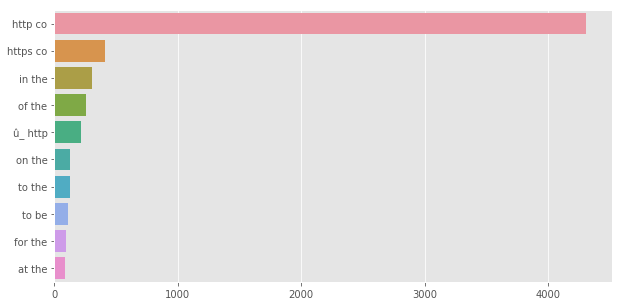

In [18]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

We will need lot of cleaning here..

## Data Cleaning
As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [19]:
df=pd.concat([tweet,test])
df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

### Removing urls

In [20]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [21]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [22]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

### Removing HTML tags

In [23]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [24]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [25]:
df['text']=df['text'].apply(lambda x : remove_html(x))

### Romoving Emojis

In [26]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [27]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))


### Removing punctuations

In [28]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [29]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

### Spelling Correction


Even if I'm not good at spelling I can correct it with python :) I will use `pyspellcheker` to do that.

In [30]:
!pip install pyspellchecker

     |████████████████████████████████| 2.5MB 867kB/s eta 0:00:01


In [31]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [32]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x)#)

## GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.

In [33]:

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        
        

In [34]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:02<00:00, 3899.11it/s]


In [35]:
corpus

[['our', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['all',
  'residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'officers',
  'no',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['just',
  'got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'directions',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'streets',
  'manitou',
  'colorado',
  'springs',
  'areas'],
 ['im', 'top', 'hill', 'i', 'see', 'fire', 'woods'],
 ['theres',
  'emergency',
  'evacuation',
  'happening',
  'building',
  'across',
  'street'],
 ['im', 'afraid', 'tornado', 'coming', 'area'],
 ['three', 'people

In [ ]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
sequences

In [ ]:
tweet_pad

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

In [ ]:
num_words

In [ ]:
embedding_matrix

In [ ]:
print(emb_vec)

## Baseline Model

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])



In [ ]:
model.summary()

In [ ]:
tweet.shape[0]

In [ ]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [ ]:
train

In [ ]:
test

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)